In [30]:
!pip install groq shap lime pandas matplotlib seaborn scikit-learn transformers nltk dotenv bs4

In [31]:
# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import json
import re
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# LLM Integration
from groq import Groq

# NLP and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XAI Libraries
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

In [32]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
if 'google.colab' in sys.modules:
    from google.colab import userdata
    GROQ_API_KEY = userdata.get("GROQ_API_KEY")
    print("Running in Google Colab")
    IN_COLAB = True
else:
    print("Not running in Google Colab")
    GROQ_API_KEY = os.getenv("GROQ_API_KEY")
    IN_COLAB = False

Running in Google Colab


In [33]:
# ============================================================================
# 2. GROQ CLIENT SETUP
# ============================================================================

# Initialize Groq client
MODEL_NAME = "openai/gpt-oss-120b"

client = Groq(api_key=GROQ_API_KEY)

In [34]:
import json
def query_llm(prompt: str, model: str, max_retries: int = 3) -> str:
    """Query Llama 3.3-70B via Groq with retry logic"""
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.3,  # Deterministic for consistency
                max_tokens=1024,
                top_p=1,
                response_format={"type": "json_object"}
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
                continue
            else:
                print(f"Error after {max_retries} attempts: {e}")
                print(json.dumps(e.__dict__, indent=2, default=str))
                # print(prompt)
                return ""

In [35]:
# ============================================================================
# 3. DATA LOADING AND PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("DATA LOADING AND PREPROCESSING")
print("=" * 80)

DATAFILE_NAME= 'Financial-QA-10k-sampled.csv'
DATA_PATH = f'../Datasets/{DATAFILE_NAME}'
if not os.path.exists(DATA_PATH):
    DATA_PATH = f'{DATAFILE_NAME}'  # Colab path
# Load dataset (replace with your actual path)
df = pd.read_csv(DATA_PATH)

OUTPUT_PATH = f'../Outputs/Chain-of-Thought/{MODEL_NAME}_1/'

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

print(f"\n✓ Dataset loaded: {len(df)} records")
print(f"✓ Columns: {list(df.columns)}")


DATA LOADING AND PREPROCESSING

✓ Dataset loaded: 1675 records
✓ Columns: ['question', 'answer', 'context', 'ticker', 'filing', 'word_count']


In [36]:
from bs4 import BeautifulSoup

# Text Cleaning Function
def clean_text(text: str) -> str:
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text.strip()

def clean_html(text: str) -> str:
    """Remove HTML tags and entities."""
    if pd.isna(text):
        return ""

    # Parse HTML and extract text
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Clean up HTML entities
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)
    text = re.sub(r'&#[0-9]+;', ' ', text)

    return text

def clean_special_chars(text: str) -> str:
    """Remove special characters and normalize text."""
    if not text:
        return ""

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove email addresses
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}', ' ', text)

    # Clean excessive whitespace
    text = re.sub(r'\\s+', ' ', text)

    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)

    return text.strip()

def normalize_case(text: str) -> str:
    """Normalize text case while preserving proper nouns."""
    if not text:
        return ""

    # Convert to lowercase but preserve some financial terms
    financial_terms = ['USD', 'CEO', 'CFO', 'SEC', 'GAAP', 'EBITDA', 'ROI', 'IPO', 'NYSE', 'NASDAQ']

    # Temporarily replace financial terms
    temp_replacements = {}
    for i, term in enumerate(financial_terms):
        if term in text:
            placeholder = f"__FINANCIAL_TERM_{i}__"
            temp_replacements[placeholder] = term
            text = text.replace(term, placeholder)

    # Convert to lowercase
    text = text.lower()

    # Restore financial terms
    for placeholder, original in temp_replacements.items():
        text = text.replace(placeholder, original)

    return text

def preprocess(text: str) -> str:
    """Apply all preprocessing steps."""
    # Step 1: Clean HTML
    text = clean_html(text)

    # Step 2: Clean special characters
    text = clean_special_chars(text)

    # Step 3: Normalize case
    text = normalize_case(text)
    return text

In [37]:
# Apply cleaning
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)
df['context'] = df['context'].apply(clean_text)
df['combined_text'] = df['question'] + ' ' + df['answer'] + ' ' + df['context']
df['combined_text'] = df['combined_text'].apply(preprocess)

print("✓ Text cleaning completed")

✓ Text cleaning completed


In [38]:
# ============================================================================
# 4. GROUND TRUTH LABEL GENERATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING GROUND TRUTH LABELS")
print("=" * 80)

# (A) SENTIMENT LABELS - Derived from context
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text: str) -> str:
    """Derive sentiment label using VADER"""
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_true'] = df['combined_text'].apply(get_sentiment_label)
# df['sentiment_true'] = df['context'].apply(get_sentiment_label)
print(f"\n✓ Sentiment labels generated")
print(f"  Distribution: {df['sentiment_true'].value_counts().to_dict()}")

# (B) TOPIC LABELS - Derived from questions
def get_topic_label(question: str) -> str:
    """Extract topic from question using keyword matching"""
    q = question.lower()
    if any(word in q for word in ['revenue', 'sales', 'income', 'profit']):
        return 'Revenue'
    elif any(word in q for word in ['risk', 'threat', 'challenge', 'vulnerability']):
        return 'Risk'
    elif any(word in q for word in ['operation', 'efficiency', 'process', 'performance']):
        return 'Operations'
    elif any(word in q for word in ['legal', 'litigation', 'lawsuit', 'compliance']):
        return 'Legal'
    elif any(word in q for word in ['management', 'executive', 'leadership', 'board']):
        return 'Management'
    else:
        return 'Other'

df['topic_true'] = df['question'].apply(get_topic_label)
print(f"\n✓ Topic labels generated")
print(f"  Distribution: {df['topic_true'].value_counts().to_dict()}")



GENERATING GROUND TRUTH LABELS

✓ Sentiment labels generated
  Distribution: {'Positive': 1197, 'Neutral': 258, 'Negative': 220}

✓ Topic labels generated
  Distribution: {'Other': 1224, 'Revenue': 219, 'Legal': 98, 'Operations': 51, 'Management': 45, 'Risk': 38}


In [39]:
# ============================================================================
# 5. CHAIN-OF-THOUGHT PROMPT TEMPLATES
# ============================================================================

print("\n" + "=" * 80)
print("Chain-of-Thought PROMPT DESIGN")
print("=" * 80)

def create_qa_prompt(question: str, context: str) -> str:
    """Chain-of-Thought prompt for Question Answering"""
    return f"""You are a financial analysis expert. Your task is to answer a question based solely on the provided context from a financial document such as a 10-K filing, earnings report, or regulatory disclosure.

Carefully follow this reasoning process and return final output in JSON only.:

1. Read the context and identify the specific parts relevant to the question.
2. Check whether the question is explicitly answered in the text.
3. Extract key facts, figures, or statements that support the answer.
4. If the answer is implied, explain how the implication follows from the context.
5. If the answer is not contained in the context, conclude that it cannot be determined.
6. Provide clear, step-by-step reasoning showing how you arrived at your conclusion.
7. At the end, provide a concise final answer in text format only.
8. The answer should be in plain text and will be fed in to JSON template.

### Task

Context: {context}
Question: {question}

Return the output ONLY in the following JSON format:

{{
  "reasoning": "...",
  "answer": "(Copy the exact answer from the context)"
}}

"""

def create_sentiment_prompt(text: str) -> str:
    """Chain-of-Thought prompt for Sentiment Detection"""
    return f"""You are a financial sentiment analysis expert. Your task is to classify the sentiment of financial text using careful step-by-step reasoning.

Analyze the sentiment of the following financial text. Consider:
- financial terminology and domain-specific cues
- forward-looking statements (guidance, projections)
- market conditions and their tone
- expressions of risk, uncertainty, or confidence
- revenue, profit, or operational performance indicators
- contextual polarity (e.g., "decline" vs. "recovery")

Follow this reasoning process:
1. Break down the text into key financial statements or claims.
2. Identify indicators of positive sentiment (e.g., growth, improvements, profitability).
3. Identify indicators of negative sentiment (e.g., losses, risks, downgrades, uncertainty).
4. Identify neutral or factual statements that do not carry sentiment.
5. Based on the balance of signals, determine whether the overall sentiment is Positive, Negative, or Neutral.
6. Provide your chain-of-thought reasoning clearly.
7. At the end, give the final sentiment label.
8. The final sentiment label should be in plain text and will be fed in to JSON template.

### Task

Text: {text}

Return ONLY this JSON:
{{
  "reasoning": "...",
  "sentiment": "Positive | Negative | Neutral"
}}

"""

def create_topic_prompt(question: str) -> str:
    """Chain-of-Thought prompt for Topic Detection"""
    return f"""You are a financial document classification expert. Your task is to classify a financial question into exactly one topic category from the list below:

[Revenue, Risk, Operations, Legal, Management, Other]

Follow this step-by-step reasoning process:

1. Carefully read the question and identify key financial terms, concepts, or phrases.
2. Match these concepts to the most relevant category by analyzing:
   - Revenue indicators (growth, sales, earnings, margins, financial performance)
   - Risk indicators (uncertainty, market risk, credit risk, regulatory risk)
   - Operations indicators (production, supply chain, logistics, costs, efficiency)
   - Legal indicators (litigation, compliance, regulatory filings, lawsuits)
   - Management indicators (leadership decisions, strategy, governance, executive actions)
   - Other (topics not fitting any of the above categories)
3. Explain why each potential category either fits or does not fit.
4. Select the single best category based on the dominant financial theme.
5. Provide clear, step-by-step reasoning.
6. At the end, provide only one final category name from the list.
7. The final category name should be in plain text and will be fed in to JSON template.

Question:
{question}

Return ONLY this JSON structure:

{{
  "reasoning": "...",
  "category": "Revenue | Risk | Operations | Legal | Management | Other"
}}
"""

print("✓ Chain-of-Thought prompts designed for all three tasks")


Chain-of-Thought PROMPT DESIGN
✓ Chain-of-Thought prompts designed for all three tasks


In [40]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================
from IPython.display import clear_output
import time
print("\n" + "=" * 80)
print("TASK 1: QUESTION ANSWERING")
print("=" * 80)

def exact_match(pred: str, gold: str) -> int:
    """Calculate exact match score"""
    return int(pred.strip().lower() == gold.strip().lower())

def token_f1(pred: str, gold: str) -> float:
    """Calculate token-level F1 score"""
    pred_tokens = set(pred.lower().split())
    gold_tokens = set(gold.lower().split())

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    overlap = len(pred_tokens & gold_tokens)
    if overlap == 0:
        return 0.0

    precision = overlap / len(pred_tokens)
    recall = overlap / len(gold_tokens)

    return 2 * precision * recall / (precision + recall)



TASK 1: QUESTION ANSWERING


In [43]:
# Generate predictions
def generate_qa_predictions_sequential():
    qa_predictions = {"qa_reasoning": [], "qa_pred": []}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating QA Predictions"):
        prompt = create_qa_prompt(row['question'], row['context'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            data = json.loads(llm_response)
            qa_predictions["qa_reasoning"].append(data["reasoning"])
            qa_predictions["qa_pred"].append(data["answer"])
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            print(llm_response)
            qa_predictions["qa_reasoning"].append("Error parsing JSON")
            qa_predictions["qa_pred"].append("Error parsing JSON")
    return qa_predictions

In [44]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================

print("\n" + "=" * 80)
print("TASK 1: QUESTION ANSWERING")
print("=" * 80)

print("Using sequential generation for Question Answering")
qa_preds = generate_qa_predictions_sequential()

df['qa_pred'] = qa_preds["qa_pred"]
df['qa_reasoning'] = qa_preds["qa_reasoning"]
print(f"\n✓ QA predictions completed")


TASK 1: QUESTION ANSWERING
Using sequential generation for Question Answering


Generating QA Predictions: 100%|██████████| 1675/1675 [24:25<00:00,  1.14it/s]


✓ QA predictions completed


In [45]:
df[df['qa_reasoning'] =='Error parsing JSON'].head()

,question,answer,context,ticker,filing,word_count,combined_text,sentiment_true,topic_true,qa_pred,qa_reasoning


In [46]:
# Evaluate QA
qa_em_scores = []
qa_f1_scores = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating QA Predictions"):
    em = exact_match(row['qa_pred'], row['answer'])
    f1 = token_f1(row['qa_pred'], row['answer'])
    qa_em_scores.append(em)
    qa_f1_scores.append(f1)

# Populate data frame
df['qa_em'] = qa_em_scores
df['qa_f1'] = qa_f1_scores

# QA Results
print("\n" + "-" * 80)
print("QUESTION ANSWERING RESULTS")
print("-" * 80)
print(f"Exact Match (EM): {np.mean(qa_em_scores):.4f}")
print(f"Token F1 Score:   {np.mean(qa_f1_scores):.4f}")

# Display sample predictions
print("\nSample QA Predictions:")
print("-" * 80)
for idx in range(min(3, len(df))):
  print(f"\nQuestion: {df.iloc[idx]['question']}")
  print(f"True Answer: {df.iloc[idx]['answer']}")
  print(f"Predicted: {df.iloc[idx]['qa_pred']}")
  print(f"EM: {df.iloc[idx]['qa_em']}, F1: {df.iloc[idx]['qa_f1']:.3f}")

Evaluating QA Predictions: 100%|██████████| 1675/1675 [00:00<00:00, 2786.03it/s]


--------------------------------------------------------------------------------
QUESTION ANSWERING RESULTS
--------------------------------------------------------------------------------
Exact Match (EM): 0.0137
Token F1 Score:   0.5405

Sample QA Predictions:
--------------------------------------------------------------------------------

Question: What is Apples commitment to workplace practices and policies concerning harassment or discrimination?
True Answer: Apple is committed to providing a workplace free of harassment or discrimination and is an equal opportunity employer.
Predicted: The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination.
EM: 0, F1: 0.757

Question: What types of products does the Company design, manufacture, and market?
True Answer: The Company designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories.
Predicted: smartph

In [47]:
# Generate predictions

def normalize_sentiment_label(text):
    if not isinstance(text, str):
        return "Neutral"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]

    mapping = {
        'positive': 'Positive',
        'pos': 'Positive',
        'negative': 'Negative',
        'neg': 'Negative',
        'neutral': 'Neutral',
        'neu': 'Neutral',
    }

    return mapping.get(first, "Neutral")

def generate_sentiment_predictions_sequential():
    sentiment_predictions = {"sentiment":[], "sentiment_reasoning":[]}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Sentiment Predictions"):
        prompt = create_sentiment_prompt(row['context'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            data = json.loads(llm_response)
            sentiment_predictions["sentiment_reasoning"].append(data["reasoning"])
            sentiment = normalize_sentiment_label(data["sentiment"])
            sentiment_predictions["sentiment"].append(sentiment)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            sentiment_predictions["sentiment_reasoning"].append("Error parsing JSON")
            sentiment_predictions["sentiment"].append("Error parsing JSON")
    return sentiment_predictions

In [48]:
# ============================================================================
# 7. TASK 2: SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 2: SENTIMENT CLASSIFICATION")
print("=" * 80)

# Generate predictions
print("\n⏳ Generating sentiment predictions...")

print("Using sequential generation for Sentiment Classification")
sentiment_preds = generate_sentiment_predictions_sequential()
df['sentiment_pred'] = sentiment_preds["sentiment"]
df['sentiment_reasoning'] = sentiment_preds["sentiment_reasoning"]

print(f"\n✓ Sentiment predictions completed")


TASK 2: SENTIMENT CLASSIFICATION

⏳ Generating sentiment predictions...
Using sequential generation for Sentiment Classification


Generating Sentiment Predictions: 100%|██████████| 1675/1675 [18:33<00:00,  1.50it/s]


✓ Sentiment predictions completed


In [49]:
# Evaluate Sentiment
y_true_sent = df['sentiment_true']
y_pred_sent = df['sentiment_pred']

sent_accuracy = accuracy_score(y_true_sent, y_pred_sent)
sent_precision = precision_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_recall = recall_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_f1 = f1_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)

print("\n" + "-" * 80)
print("SENTIMENT CLASSIFICATION RESULTS")
print("-" * 80)
print(f"Accuracy:  {sent_accuracy:.4f}")
print(f"Precision: {sent_precision:.4f} (macro)")
print(f"Recall:    {sent_recall:.4f} (macro)")
print(f"F1-Score:  {sent_f1:.4f} (macro)")

print("\nClassification Report:")
print(classification_report(y_true_sent, y_pred_sent))

# Confusion Matrix
cm_sent = confusion_matrix(y_true_sent, y_pred_sent)
print("\nConfusion Matrix:")
print(cm_sent)


--------------------------------------------------------------------------------
SENTIMENT CLASSIFICATION RESULTS
--------------------------------------------------------------------------------
Accuracy:  0.3910
Precision: 0.4725 (macro)
Recall:    0.4980 (macro)
F1-Score:  0.3793 (macro)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.33      0.40      0.36       220
     Neutral       0.20      0.79      0.33       258
    Positive       0.88      0.30      0.45      1197

    accuracy                           0.39      1675
   macro avg       0.47      0.50      0.38      1675
weighted avg       0.71      0.39      0.42      1675


Confusion Matrix:
[[ 88 111  21]
 [ 27 204  27]
 [152 682 363]]


In [50]:
# Generate predictions sequentially
def normalize_topic_label(text):
    if not isinstance(text, str):
        return "Other"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]
    mapping = {
        'revenue': 'Revenue',
        'risk': 'Risk',
        'operations': 'Operations',
        'legal': 'Legal',
        'management': 'Management',
        'other': 'Other'
    }

    return mapping.get(first, "Other")

def generate_topic_predictions_sequential():
    topic_predictions = {"topic":[], "topic_reasoning":[]}
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Topic Predictions"):
        prompt = create_topic_prompt(row['question'])
        llm_response = query_llm(prompt, MODEL_NAME)
        try:
            data = json.loads(llm_response)
            topic_predictions["topic_reasoning"].append(data["reasoning"])
            topic = normalize_topic_label(data["category"])
            topic_predictions["topic"].append(topic)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            topic_predictions["topic_reasoning"].append("Error parsing JSON")
            topic_predictions["topic"].append("Error parsing JSON")
    return topic_predictions

In [51]:
# ============================================================================
# 8. TASK 3: TOPIC DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 3: TOPIC DETECTION")
print("=" * 80)

# Generate predictions
print("\n⏳ Generating Topic Predictions...")
print("Using sequential generation for Topic Detection")

topic_preds = generate_topic_predictions_sequential()
df['topic_pred'] = topic_preds["topic"]
df['topic_reasoning'] = topic_preds["topic_reasoning"]

print(f"\n✓ Topic predictions completed")


TASK 3: TOPIC DETECTION

⏳ Generating Topic Predictions...
Using sequential generation for Topic Detection


Generating Topic Predictions: 100%|██████████| 1675/1675 [20:10<00:00,  1.38it/s]


✓ Topic predictions completed


In [53]:
df[df['topic_reasoning'] == 'Error parsing JSON'].head()

,question,answer,context,ticker,filing,word_count,combined_text,sentiment_true,topic_true,qa_pred,qa_reasoning,qa_em,qa_f1,sentiment_pred,sentiment_reasoning,topic_pred,topic_reasoning


In [52]:
# Evaluate Topic Detection
y_true_topic = df['topic_true']
y_pred_topic = df['topic_pred']

topic_accuracy = accuracy_score(y_true_topic, y_pred_topic)
topic_macro_f1 = f1_score(y_true_topic, y_pred_topic, average='macro', zero_division=0)
topic_micro_f1 = f1_score(y_true_topic, y_pred_topic, average='micro', zero_division=0)

print("\n" + "-" * 80)
print("TOPIC DETECTION RESULTS")
print("-" * 80)
print(f"Accuracy:   {topic_accuracy:.4f}")
print(f"Macro-F1:   {topic_macro_f1:.4f}")
print(f"Micro-F1:   {topic_micro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_topic, y_pred_topic))

# Confusion Matrix
cm_topic = confusion_matrix(y_true_topic, y_pred_topic,
                            labels=['Revenue', 'Risk', 'Operations', 'Legal', 'Management', 'Other'])
print("\nConfusion Matrix:")
print(cm_topic)


--------------------------------------------------------------------------------
TOPIC DETECTION RESULTS
--------------------------------------------------------------------------------
Accuracy:   0.3206
Macro-F1:   0.3081
Micro-F1:   0.3206

Classification Report:
              precision    recall  f1-score   support

       Legal       0.24      1.00      0.39        98
  Management       0.12      0.73      0.21        45
  Operations       0.08      0.35      0.13        51
       Other       0.97      0.14      0.24      1224
     Revenue       0.53      0.84      0.65       219
        Risk       0.13      0.84      0.22        38

    accuracy                           0.32      1675
   macro avg       0.35      0.65      0.31      1675
weighted avg       0.80      0.32      0.30      1675


Confusion Matrix:
[[185   4  10  10   7   3]
 [  0  32   2   3   1   0]
 [  7   7  18   9   8   2]
 [  0   0   0  98   0   0]
 [  4   1   3   4  33   0]
 [153 206 195 277 222 171]]


In [54]:
print("\n" + "=" * 80)
print("CONSOLIDATED RESULTS SUMMARY")
print("=" * 80)

results_summary = pd.DataFrame({
    'Task': ['Question Answering', 'Question Answering', 'Sentiment Classification',
             'Sentiment Classification', 'Sentiment Classification', 'Sentiment Classification',
             'Topic Detection', 'Topic Detection', 'Topic Detection'],
    'Metric': ['Exact Match', 'Token F1', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)',
               'F1 (Macro)', 'Accuracy', 'Macro-F1', 'Micro-F1'],
    'Score': [
        np.mean(qa_em_scores),
        np.mean(qa_f1_scores),
        sent_accuracy,
        sent_precision,
        sent_recall,
        sent_f1,
        topic_accuracy,
        topic_macro_f1,
        topic_micro_f1
    ]
})

print("\n", results_summary.to_string(index=False))


CONSOLIDATED RESULTS SUMMARY

                     Task            Metric    Score
      Question Answering       Exact Match 0.013731
      Question Answering          Token F1 0.540485
Sentiment Classification          Accuracy 0.391045
Sentiment Classification Precision (Macro) 0.472471
Sentiment Classification    Recall (Macro) 0.497985
Sentiment Classification        F1 (Macro) 0.379329
         Topic Detection          Accuracy 0.320597
         Topic Detection          Macro-F1 0.308099
         Topic Detection          Micro-F1 0.320597



GENERATING VISUALIZATIONS
✓ Visualizations saved as 'financial_analysis_results.png'


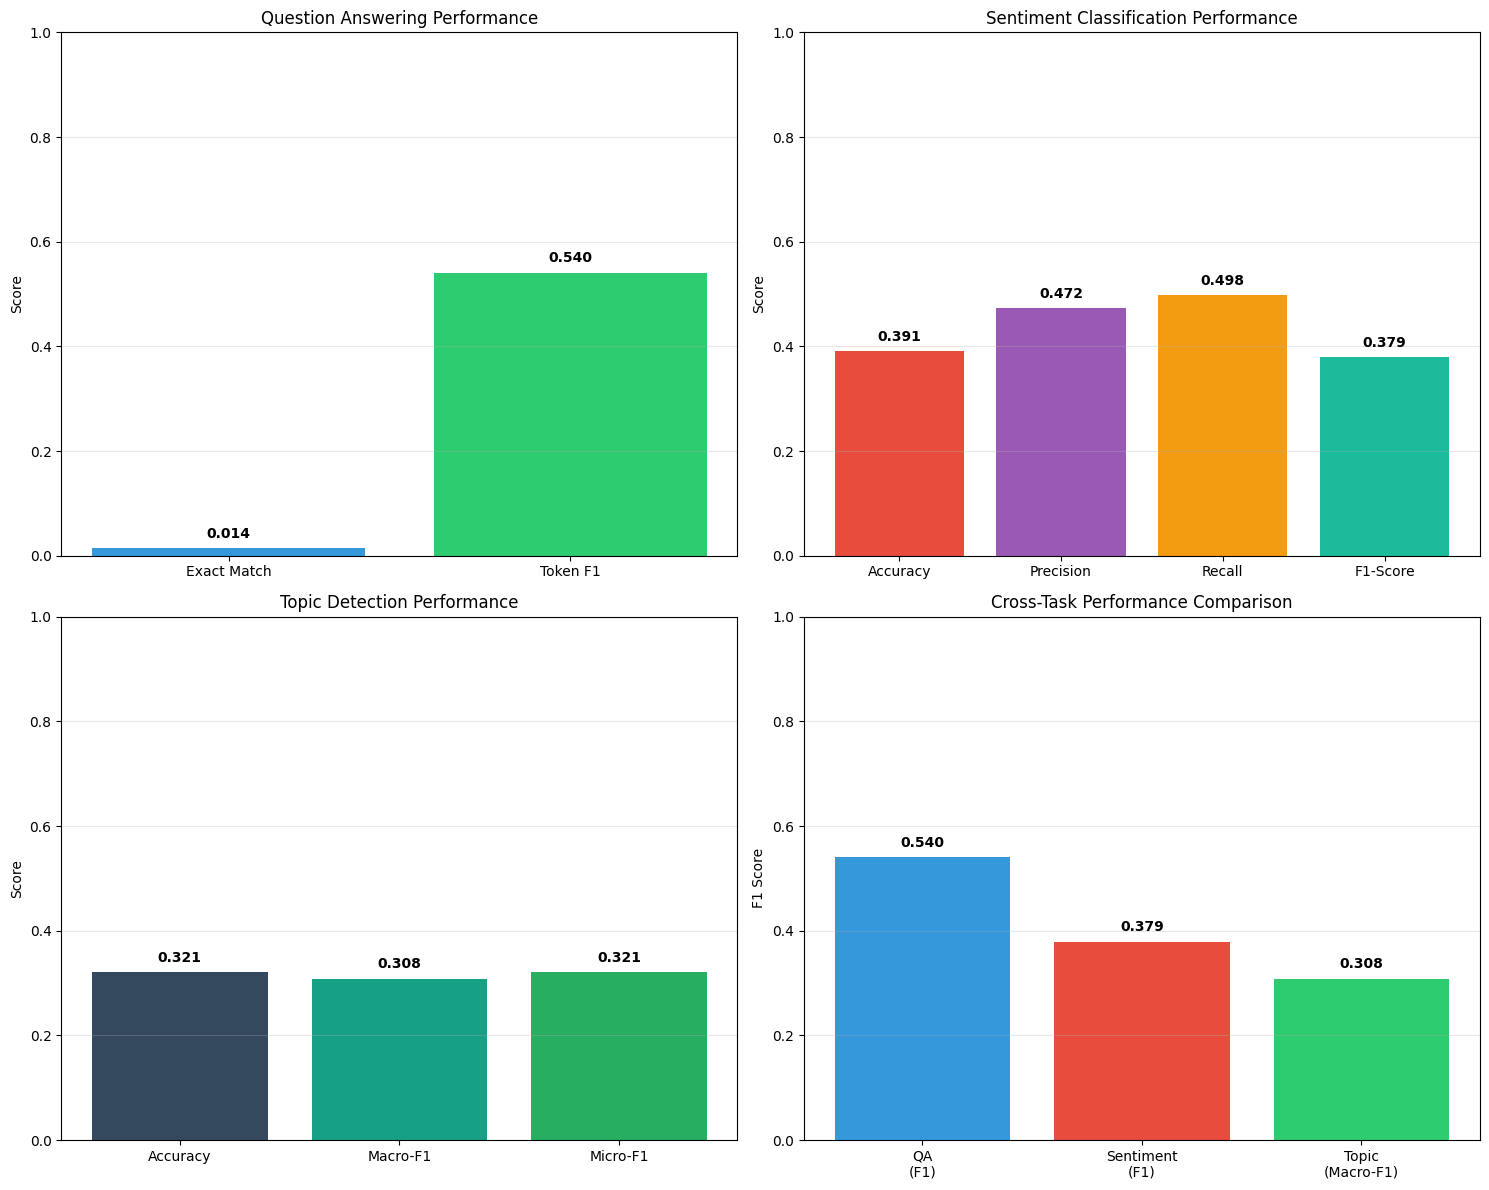

In [55]:
# ============================================================================
# 10. VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: QA Performance
ax1 = axes[0, 0]
qa_metrics = ['Exact Match', 'Token F1']
qa_scores = [np.mean(qa_em_scores), np.mean(qa_f1_scores)]
ax1.bar(qa_metrics, qa_scores, color=['#3498db', '#2ecc71'])
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_title('Question Answering Performance')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(qa_scores):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Sentiment Classification
ax2 = axes[0, 1]
sent_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
sent_scores = [sent_accuracy, sent_precision, sent_recall, sent_f1]
ax2.bar(sent_metrics, sent_scores, color=['#e74c3c', '#9b59b6', '#f39c12', '#1abc9c'])
ax2.set_ylim(0, 1)
ax2.set_ylabel('Score')
ax2.set_title('Sentiment Classification Performance')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(sent_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Topic Detection
ax3 = axes[1, 0]
topic_metrics = ['Accuracy', 'Macro-F1', 'Micro-F1']
topic_scores = [topic_accuracy, topic_macro_f1, topic_micro_f1]
ax3.bar(topic_metrics, topic_scores, color=['#34495e', '#16a085', '#27ae60'])
ax3.set_ylim(0, 1)
ax3.set_ylabel('Score')
ax3.set_title('Topic Detection Performance')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(topic_scores):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 4: Task Comparison
ax4 = axes[1, 1]
tasks = ['QA\n(F1)', 'Sentiment\n(F1)', 'Topic\n(Macro-F1)']
comparison_scores = [np.mean(qa_f1_scores), sent_f1, topic_macro_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax4.bar(tasks, comparison_scores, color=colors)
ax4.set_ylim(0, 1)
ax4.set_ylabel('F1 Score')
ax4.set_title('Cross-Task Performance Comparison')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_scores):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/financial_analysis_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualizations saved as 'financial_analysis_results.png'")
plt.show()

In [56]:
# ============================================================================
# 11. SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save detailed predictions
output_df = df[['question', 'answer', 'context',
                'qa_pred', 'qa_em', 'qa_f1',
                'sentiment_true', 'sentiment_pred',
                'topic_true', 'topic_pred']]
output_df.to_csv(f'{OUTPUT_PATH}/financial_analysis_predictions.csv', index=False)
print("✓ Detailed predictions saved to 'financial_analysis_predictions.csv'")

# Save summary results
results_summary.to_csv(f'{OUTPUT_PATH}/financial_analysis_summary.csv', index=False)
print("✓ Summary results saved to 'financial_analysis_summary.csv'")

print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("=" * 80)
print(f"\nModel: {MODEL_NAME}")
print(f"Prompting Strategy: Chain-of-Thought")
print(f"Total Records Processed: {len(df)}")
print(f"\nKey Findings:")
print(f"  • QA Token F1: {np.mean(qa_f1_scores):.3f}")
print(f"  • Sentiment F1: {sent_f1:.3f}")
print(f"  • Topic Macro-F1: {topic_macro_f1:.3f}")
print("=" * 80)


SAVING RESULTS
✓ Detailed predictions saved to 'financial_analysis_predictions.csv'
✓ Summary results saved to 'financial_analysis_summary.csv'

PIPELINE COMPLETED SUCCESSFULLY

Model: openai/gpt-oss-120b
Prompting Strategy: Chain-of-Thought
Total Records Processed: 1675

Key Findings:
  • QA Token F1: 0.540
  • Sentiment F1: 0.379
  • Topic Macro-F1: 0.308


In [57]:
# ============================================================================
# 12. EXPLAINABLE AI (XAI) - SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("EXPLAINABLE AI ANALYSIS")
print("=" * 80)

# ============================================================================
# 12.1 PREPARE SURROGATE MODEL FOR SENTIMENT
# ============================================================================

print("\n[1/4] Training surrogate model for Sentiment Classification...")

# Create TF-IDF features
tfidf_sent = TfidfVectorizer(max_features=100, ngram_range=(1, 2), dtype=float)
# X_sent = tfidf_sent.fit_transform(df['context'])
X_sent = tfidf_sent.fit_transform(df['combined_text'])

# Train a surrogate Random Forest model
rf_sent = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_sent.fit(X_sent, df['sentiment_true'])

print(f"✓ Surrogate model trained (Accuracy: {rf_sent.score(X_sent, df['sentiment_true']):.3f})")


EXPLAINABLE AI ANALYSIS

[1/4] Training surrogate model for Sentiment Classification...
✓ Surrogate model trained (Accuracy: 0.769)



[2/4] Generating SHAP explanations for Sentiment...


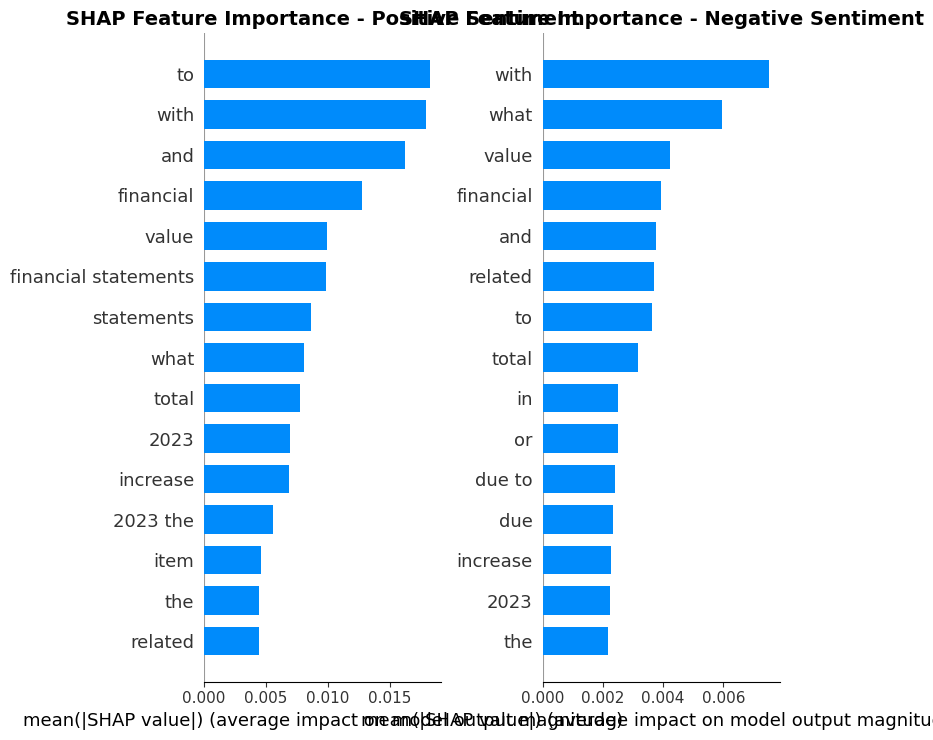

In [58]:
# ============================================================================
# 12.2 SHAP ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[2/4] Generating SHAP explanations for Sentiment...")

X_sent_dense = X_sent.toarray()

# Create SHAP explainer
explainer_sent = shap.TreeExplainer(rf_sent)
shap_values_sent = explainer_sent.shap_values(X_sent_dense)

# SHAP Summary Plot
fig_shap_sent, axes_shap = plt.subplots(1, 2, figsize=(18, 6))

# Plot for each sentiment class (assuming 3 classes: Negative=0, Neutral=1, Positive=2)
class_names_sent = ['Negative', 'Neutral', 'Positive']
feature_names_sent = tfidf_sent.get_feature_names_out()

shap_values_class_2 = shap_values_sent[:, :, 2]
# Summary plot for Positive class
if len(shap_values_sent) >= 3:
    plt.sca(axes_shap[0])
    shap_values_class_2 = shap_values_sent[:, :, 2]
    shap.summary_plot(shap_values_class_2, X_sent_dense,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[0].set_title('SHAP Feature Importance - Positive Sentiment', fontsize=14, fontweight='bold')

    # Summary plot for Negative class
    plt.sca(axes_shap[1])
    shap_values_negative = shap_values_sent[:, :, 0]
    shap.summary_plot(shap_values_negative, X_sent,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[1].set_title('SHAP Feature Importance - Negative Sentiment', fontsize=14, fontweight='bold')


[2/4] Generating SHAP explanations for Sentiment...
✓ SHAP plots saved as 'xai_shap_sentiment.png'


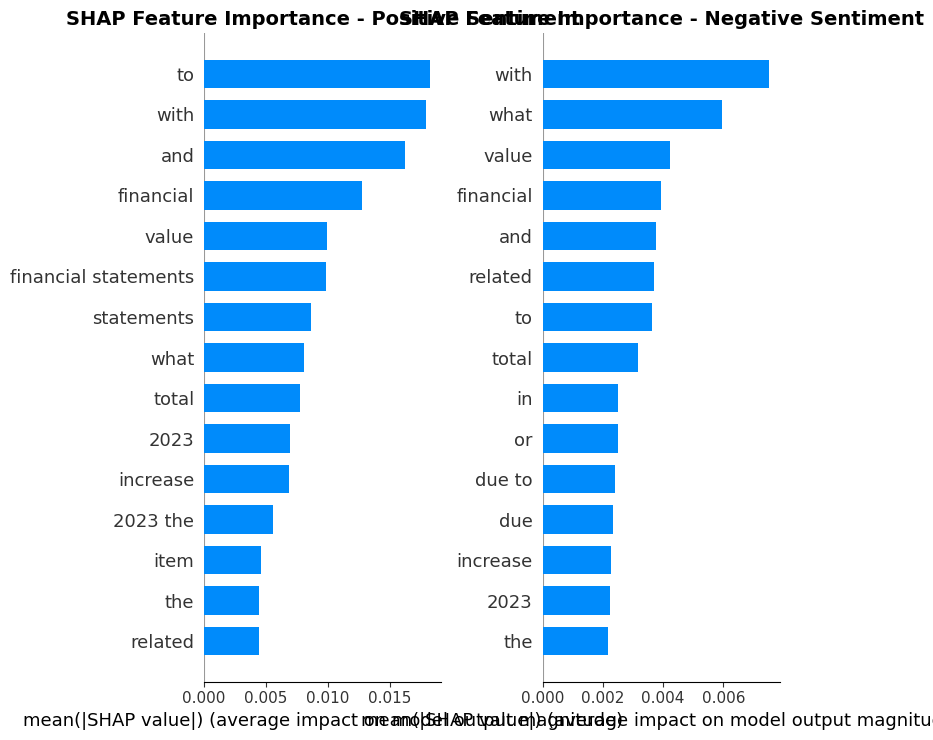


Generating SHAP force plot for sample prediction...


✓ SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'


<Figure size 1400x300 with 0 Axes>

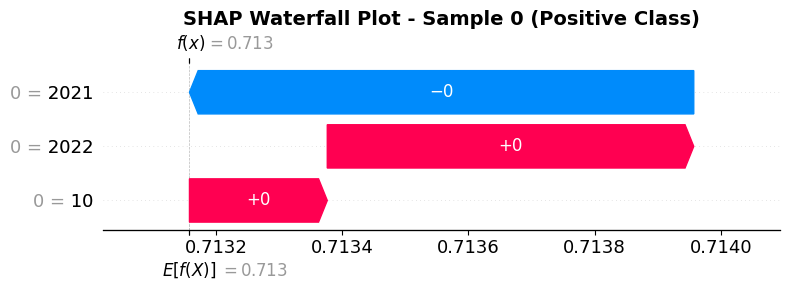

In [59]:
# ============================================================================
# 12.2 SHAP ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[2/4] Generating SHAP explanations for Sentiment...")

X_sent_dense = X_sent.toarray()

# Create SHAP explainer
explainer_sent = shap.TreeExplainer(rf_sent)
shap_values_sent = explainer_sent.shap_values(X_sent_dense)

# SHAP Summary Plot
fig_shap_sent, axes_shap = plt.subplots(1, 2, figsize=(18, 6))

# Plot for each sentiment class (assuming 3 classes: Negative=0, Neutral=1, Positive=2)
class_names_sent = ['Negative', 'Neutral', 'Positive']
feature_names_sent = tfidf_sent.get_feature_names_out()

shap_values_class_2 = shap_values_sent[:, :, 2]
# Summary plot for Positive class
if len(shap_values_sent) >= 3:
    plt.sca(axes_shap[0])
    shap_values_class_2 = shap_values_sent[:, :, 2]
    shap.summary_plot(shap_values_class_2, X_sent_dense,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[0].set_title('SHAP Feature Importance - Positive Sentiment', fontsize=14, fontweight='bold')

    # Summary plot for Negative class
    plt.sca(axes_shap[1])
    shap_values_negative = shap_values_sent[:, :, 0]
    shap.summary_plot(shap_values_negative, X_sent,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[1].set_title('SHAP Feature Importance - Negative Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_shap_sentiment.png', dpi=300, bbox_inches='tight')
print("✓ SHAP plots saved as 'xai_shap_sentiment.png'")
plt.show()

# SHAP Force Plot for a specific example
print("\nGenerating SHAP force plot for sample prediction...")
sample_idx = 0
shap.initjs()

# Individual SHAP explanation
if len(shap_values_sent) >= 3:
    fig_force = plt.figure(figsize=(14, 3))
    shap_explanation = shap.Explanation(
        values=shap_values_sent[2][sample_idx],
        base_values=explainer_sent.expected_value[2],
        data=X_sent[sample_idx].toarray()[0],
        feature_names=feature_names_sent
    )

    # Waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap_explanation, max_display=15, show=False)
    plt.title(f'SHAP Waterfall Plot - Sample {sample_idx} (Positive Class)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/xai_shap_waterfall_sentiment.png', dpi=300, bbox_inches='tight')
    print("✓ SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'")
    plt.show()


[3/4] Generating LIME explanations for Sentiment...
✓ LIME plots saved as 'xai_lime_sentiment.png'


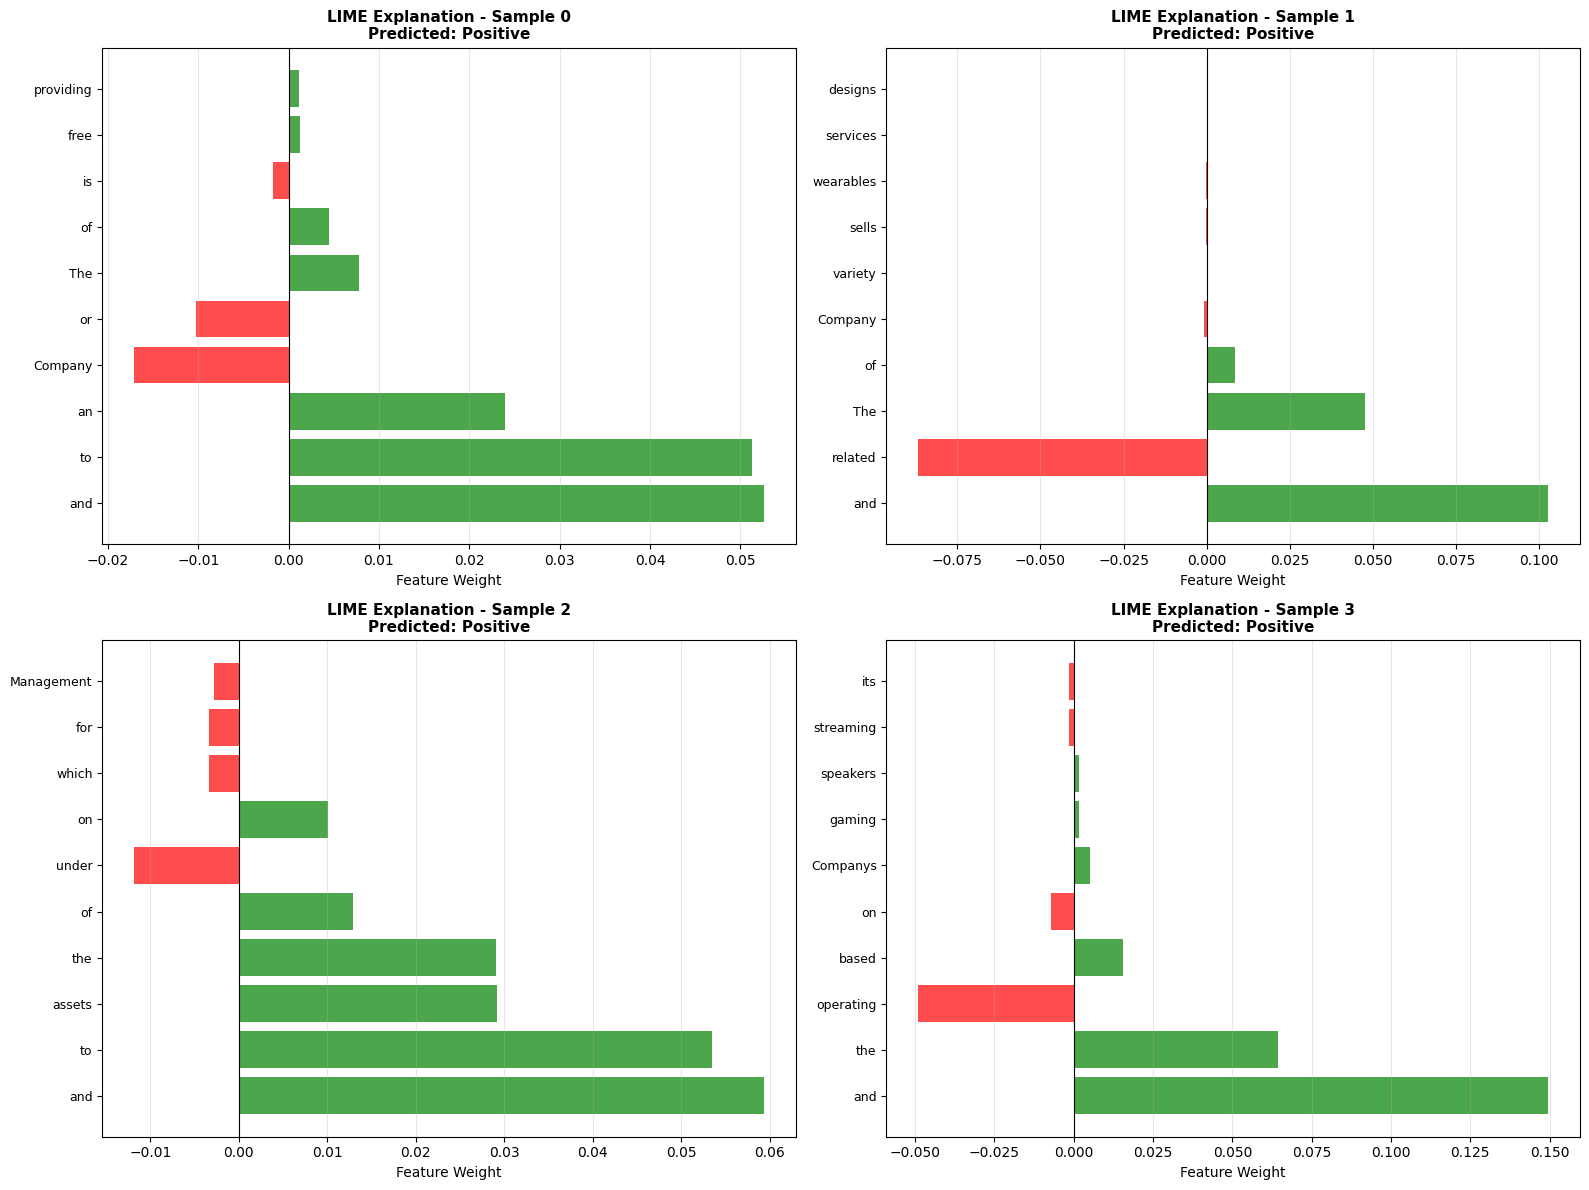

In [60]:
# ============================================================================
# 12.3 LIME ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[3/4] Generating LIME explanations for Sentiment...")

# Create LIME explainer
def sentiment_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_sent.transform(texts)
    return rf_sent.predict_proba(X)

lime_sent = LimeTextExplainer(class_names=class_names_sent)

# Generate LIME explanation for sample instances
lime_explanations_sent = []
fig_lime_sent, axes_lime = plt.subplots(2, 2, figsize=(16, 12))
axes_lime = axes_lime.flatten()

for idx in range(min(4, len(df))):
    exp = lime_sent.explain_instance(
        df.iloc[idx]['context'],
        sentiment_predictor,
        num_features=10,
        top_labels=1
    )
    lime_explanations_sent.append(exp)

    # Plot explanation
    fig_temp = exp.as_pyplot_figure(label=exp.top_labels[0])

    # Transfer to subplot
    ax = axes_lime[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted: {class_names_sent[exp.top_labels[0]]}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

    plt.close(fig_temp)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_sentiment.png', dpi=300, bbox_inches='tight')
print("✓ LIME plots saved as 'xai_lime_sentiment.png'")
plt.show()

In [61]:
# ============================================================================
# 12.4 PREPARE SURROGATE MODEL FOR TOPIC DETECTION
# ============================================================================

print("\n[4/4] Training surrogate model for Topic Detection...")

# Create TF-IDF features for topics
tfidf_topic = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_topic = tfidf_topic.fit_transform(df['question'])

# Train a surrogate Random Forest model
rf_topic = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_topic.fit(X_topic, df['topic_true'])

print(f"✓ Surrogate model trained (Accuracy: {rf_topic.score(X_topic, df['topic_true']):.3f})")


[4/4] Training surrogate model for Topic Detection...
✓ Surrogate model trained (Accuracy: 0.895)



Generating SHAP explanations for Topic Detection...
✓ SHAP topic plots saved as 'xai_shap_topic.png'


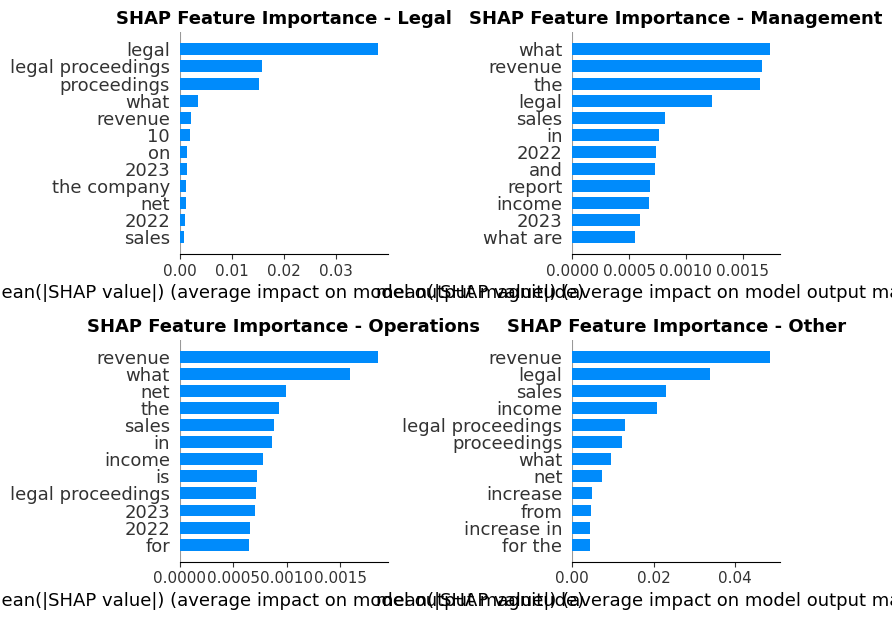

In [62]:
# ============================================================================
# 12.5 SHAP ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating SHAP explanations for Topic Detection...")

X_topic_dense = X_topic.toarray()

# Create SHAP explainer
explainer_topic = shap.TreeExplainer(rf_topic)
shap_values_topic = explainer_topic.shap_values(X_topic_dense)

# SHAP Summary Plot for Topics
fig_shap_topic, axes_shap_topic = plt.subplots(2, 2, figsize=(18, 12))
axes_shap_topic = axes_shap_topic.flatten()

# Get unique topics and their indices
unique_topics = rf_topic.classes_
feature_names_topic = tfidf_topic.get_feature_names_out()

for i, topic in enumerate(unique_topics[:4]):  # Show first 4 topics
    if i < len(shap_values_topic):
        plt.sca(axes_shap_topic[i])
        shap_values_class_i = shap_values_topic[:, :, i]
        shap.summary_plot(shap_values_class_i, X_topic,
                         feature_names=feature_names_topic,
                         plot_type="bar", show=False, max_display=12)
        axes_shap_topic[i].set_title(f'SHAP Feature Importance - {topic}',
                                     fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_shap_topic.png', dpi=300, bbox_inches='tight')
print("✓ SHAP topic plots saved as 'xai_shap_topic.png'")
plt.show()


Generating LIME explanations for Topic Detection...
✓ LIME topic plots saved as 'xai_lime_topic.png'


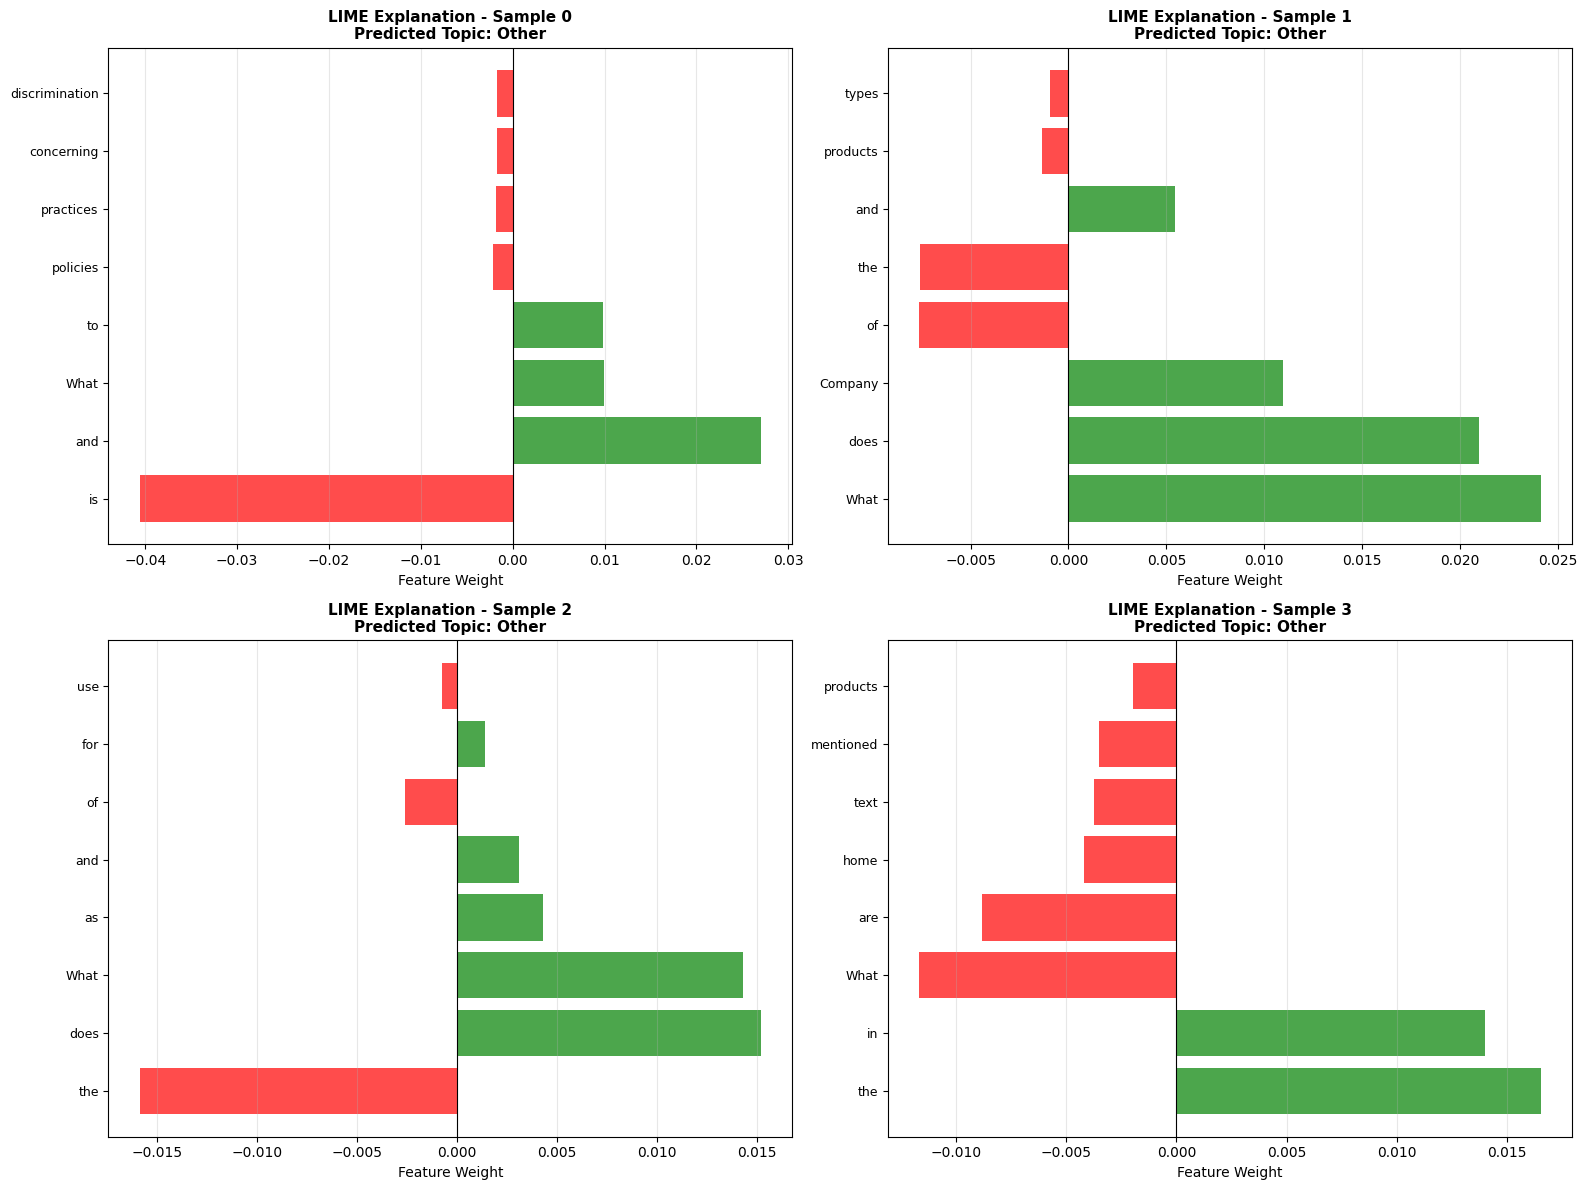

In [63]:
# ============================================================================
# 12.6 LIME ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating LIME explanations for Topic Detection...")

# Create LIME explainer for topics
def topic_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_topic.transform(texts)
    return rf_topic.predict_proba(X)

lime_topic = LimeTextExplainer(class_names=unique_topics.tolist())

# Generate LIME explanation for sample instances
fig_lime_topic, axes_lime_topic = plt.subplots(2, 2, figsize=(16, 12))
axes_lime_topic = axes_lime_topic.flatten()

for idx in range(min(4, len(df))):
    exp = lime_topic.explain_instance(
        df.iloc[idx]['question'],
        topic_predictor,
        num_features=8,
        top_labels=1
    )

    # Plot explanation
    ax = axes_lime_topic[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    pred_topic = unique_topics[exp.top_labels[0]]
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted Topic: {pred_topic}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_topic.png', dpi=300, bbox_inches='tight')
print("✓ LIME topic plots saved as 'xai_lime_topic.png'")
plt.show()


Generating Feature Importance Comparison...
✓ Feature importance plots saved as 'xai_feature_importance.png'


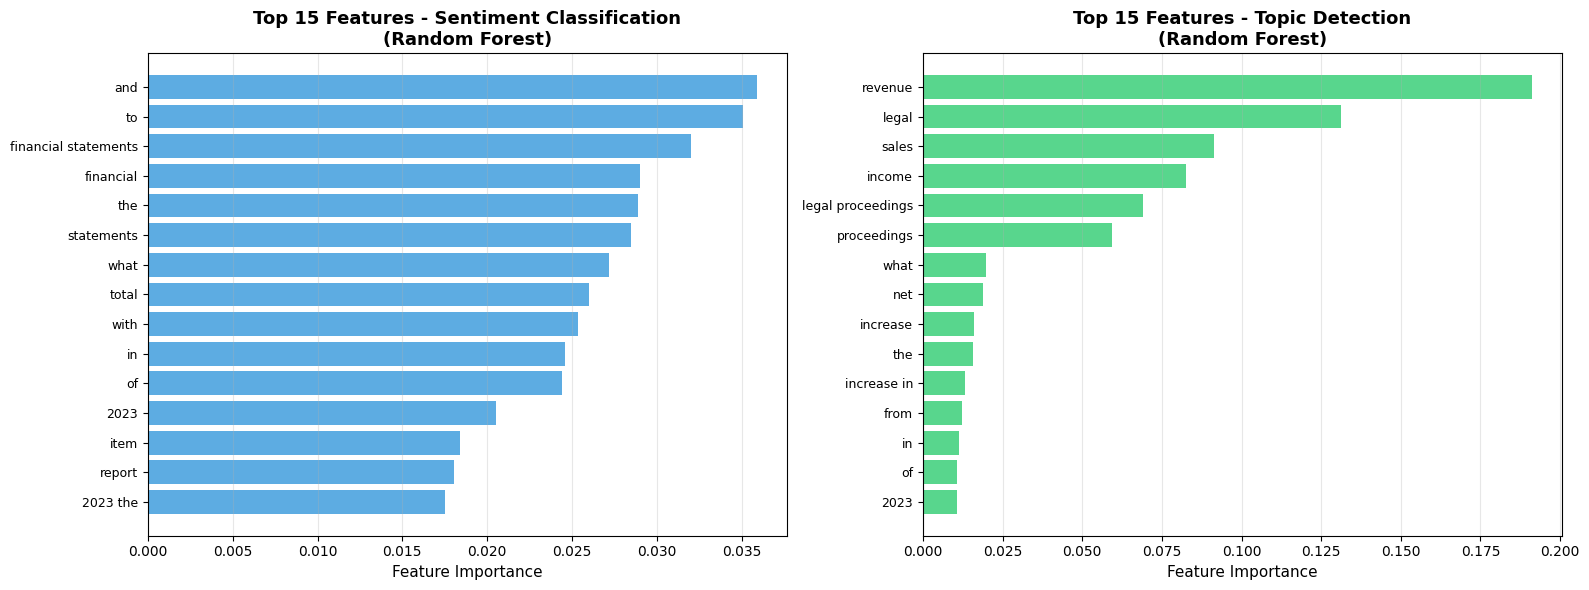

In [64]:
# ============================================================================
# 12.7 FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\nGenerating Feature Importance Comparison...")

fig_importance, axes_imp = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment Feature Importance
feature_importance_sent = rf_sent.feature_importances_
top_n = 15
indices_sent = np.argsort(feature_importance_sent)[-top_n:]
top_features_sent = [feature_names_sent[i] for i in indices_sent]
top_importance_sent = feature_importance_sent[indices_sent]

axes_imp[0].barh(range(top_n), top_importance_sent, color='#3498db', alpha=0.8)
axes_imp[0].set_yticks(range(top_n))
axes_imp[0].set_yticklabels(top_features_sent, fontsize=9)
axes_imp[0].set_xlabel('Feature Importance', fontsize=11)
axes_imp[0].set_title('Top 15 Features - Sentiment Classification\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[0].grid(axis='x', alpha=0.3)

# Topic Feature Importance
feature_importance_topic = rf_topic.feature_importances_
indices_topic = np.argsort(feature_importance_topic)[-top_n:]
top_features_topic = [feature_names_topic[i] for i in indices_topic]
top_importance_topic = feature_importance_topic[indices_topic]

axes_imp[1].barh(range(top_n), top_importance_topic, color='#2ecc71', alpha=0.8)
axes_imp[1].set_yticks(range(top_n))
axes_imp[1].set_yticklabels(top_features_topic, fontsize=9)
axes_imp[1].set_xlabel('Feature Importance', fontsize=11)
axes_imp[1].set_title('Top 15 Features - Topic Detection\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plots saved as 'xai_feature_importance.png'")
plt.show()

In [65]:
# ============================================================================
# 12.8 XAI METRICS AND SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("XAI ANALYSIS SUMMARY")
print("=" * 80)

# Calculate explainability metrics
xai_metrics = {
    'Task': [],
    'Surrogate Model Accuracy': [],
    'Top Feature': [],
    'Feature Importance': []
}

# Sentiment XAI metrics
xai_metrics['Task'].append('Sentiment Classification')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_sent.score(X_sent, df['sentiment_true']):.4f}")
top_sent_idx = np.argmax(feature_importance_sent)
xai_metrics['Top Feature'].append(feature_names_sent[top_sent_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_sent[top_sent_idx]:.4f}")

# Topic XAI metrics
xai_metrics['Task'].append('Topic Detection')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_topic.score(X_topic, df['topic_true']):.4f}")
top_topic_idx = np.argmax(feature_importance_topic)
xai_metrics['Top Feature'].append(feature_names_topic[top_topic_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_topic[top_topic_idx]:.4f}")

xai_summary_df = pd.DataFrame(xai_metrics)
print("\n", xai_summary_df.to_string(index=False))

# Save XAI summary
xai_summary_df.to_csv(f'{OUTPUT_PATH}/xai_analysis_summary.csv', index=False)
print("\n✓ XAI summary saved to 'xai_analysis_summary.csv'")


XAI ANALYSIS SUMMARY

                     Task Surrogate Model Accuracy Top Feature Feature Importance
Sentiment Classification                   0.7690         and             0.0359
         Topic Detection                   0.8949     revenue             0.1911

✓ XAI summary saved to 'xai_analysis_summary.csv'


In [66]:
# ============================================================================
# 12.9 DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
# ============================================================================

print("\n" + "-" * 80)
print("DETAILED XAI EXPLANATIONS FOR KEY INSTANCES")
print("-" * 80)

# Select one instance from each task for detailed explanation
sample_idx_detailed = 0

print(f"\n📋 Sample {sample_idx_detailed} - Detailed Analysis")
print("-" * 80)

# Original data
print(f"\nOriginal Context: {df.iloc[sample_idx_detailed]['context'][:200]}...")
print(f"True Sentiment: {df.iloc[sample_idx_detailed]['sentiment_true']}")
print(f"Predicted Sentiment: {df.iloc[sample_idx_detailed]['sentiment_pred']}")

# SHAP values for this instance
if len(shap_values_sent) >= 3:
    print(f"\nTop 5 SHAP Features (Sentiment):")
    shap_instance = shap_values_sent[2][sample_idx_detailed]  # Positive class
    top_shap_indices = np.argsort(np.abs(shap_instance))[-5:][::-1]
    for i, idx in enumerate(top_shap_indices, 1):
        print(f"  {i}. {feature_names_sent[idx]}: {shap_instance[idx]:.4f}")

# LIME explanation
print(f"\nLIME Explanation (Sentiment):")
lime_exp_detailed = lime_explanations_sent[sample_idx_detailed]
for feat, weight in lime_exp_detailed.as_list(label=lime_exp_detailed.top_labels[0])[:5]:
    print(f"  '{feat}': {weight:.4f}")

print("\n" + "=" * 80)
print("XAI ANALYSIS COMPLETED")
print("=" * 80)
print("\n✓ Generated Visualizations:")
print("  1. xai_shap_sentiment.png - SHAP feature importance for sentiment")
print("  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot")
print("  3. xai_lime_sentiment.png - LIME explanations for sentiment")
print("  4. xai_shap_topic.png - SHAP feature importance for topics")
print("  5. xai_lime_topic.png - LIME explanations for topics")
print("  6. xai_feature_importance.png - Feature importance comparison")
print("\n✓ Saved Reports:")
print("  1. xai_analysis_summary.csv - XAI metrics summary")

print("\n" + "=" * 80)
print("COMPLETE PIPELINE FINISHED")
print("=" * 80)


--------------------------------------------------------------------------------
DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
--------------------------------------------------------------------------------

📋 Sample 0 - Detailed Analysis
--------------------------------------------------------------------------------

Original Context: The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination....
True Sentiment: Positive
Predicted Sentiment: Neutral

Top 5 SHAP Features (Sentiment):
  1. 2021: -0.0008
  2. 2022: 0.0006
  3. 10: 0.0002

LIME Explanation (Sentiment):
  'and': 0.0527
  'to': 0.0513
  'an': 0.0239
  'Company': -0.0171
  'or': -0.0102

XAI ANALYSIS COMPLETED

✓ Generated Visualizations:
  1. xai_shap_sentiment.png - SHAP feature importance for sentiment
  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot
  3. xai_lime_sentiment.png - LIME explanations for sentiment
  4. xai_sh